In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
import os
import cooler
import cooltools
import numpy as np
from cooltools import eigdecomp
import bioframe
from pathlib import Path
import multiprocess as mp
import pandas as pd

from copy import copy

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


In [4]:
ins_samples = {
    "Hap1-WT-combined.hg19" : "Hap1-WT-combined.mcool",
    "PolII-IAA.hg19" : "PolII-IAA.hg19.mapq_30.1000.mcool",
    "PolII-NT.hg19" : "PolII-NT.hg19.mapq_30.1000.mcool",
    "all_CTCF_combined.hg19" : "all_combined.mcool",
    "noCTCF_IAA_combined.hg19" : "noCTCF_IAA_combined.mcool",
    
    "all_CTCF_combined.hg19" : "all_combined.mcool",
    "noCTCF_IAA_combined.hg19" : "noCTCF_IAA_combined.mcool",
    
    "CkoCT442_NT_pool.hg19" : "CkoCT442-NT-pool.mcool",
    "CkoCT442_IAA_pool.hg19" : "CkoCT442-IAA-pool.mcool",
    # RAD21 degron for HCT from Rao et al 2017 ...
    "RAD21-IAA.hg19" : "RAD21-AID-IAA-6H.hg19.mapq_30.1000.mcool",
    "RAD21-NT.hg19" : "RAD21-AID-NT.hg19.mapq_30.1000.mcool",

    "CkoC442-IAA48H-R1-T1.hg19" : "CkoC442-IAA48H-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoC442-NT-R1-T1.hg19" : "./wt_like_coolers_to_combine/CkoC442-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoCT442-AAVS1sg2-4-NT-R1-T1.hg19" : "CkoCT442-AAVS1sg2-4-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "CkoCT442-DDX55sg2-B-NT-R1-T1.hg19" : "CkoCT442-DDX55sg2-B-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool",
    "G1-NT.hg19" : "G1-NT.hg19.1kb.mcool",
    "G1-IAA.hg19" : "G1-IAA.hg19.1kb.mcool",
    
    # Mutants time !!!
    # Knock-outs - genes were deleted ...
    "mutControl-NT.hg19":"CkoCT442-AAVS1-NT-pool.mcool",
    "mutControl-IAA.hg19":"CkoCT442-AAVS1-IAA-pool.mcool",
    "mutDDX55-NT.hg19":"DDX55-clones-NT.hg19.mapq_30.1000.mcool",
    "mutDDX55-IAA.hg19":"DDX55-clones-IAA.hg19.mapq_30.1000.mcool",
    "mutTAF5L-NT.hg19":"TAF5L-clones-NT.hg19.mapq_30.1000.mcool",
    "mutTAF5L-IAA.hg19":"TAF5L-clones-IAA.hg19.mapq_30.1000.mcool",
    # Knock-downs - genes were silenced/deplted (siRNA) ...
    "siControl-NT.hg19":"siCTRL-NT.hg19.mapq_30.1000.mcool",
    "siControl-IAA.hg19":"siCTRL-IAA.hg19.mapq_30.1000.mcool",
    "siDDX55-NT.hg19":"siDDX55-NT.hg19.mapq_30.1000.mcool",
    "siDDX55-IAA.hg19":"siDDX55-IAA.hg19.mapq_30.1000.mcool",
    "siTAF5L-NT.hg19":"siTAF5L-NT.hg19.mapq_30.1000.mcool",
    "siTAF5L-IAA.hg19":"siTAF5L-IAA.hg19.mapq_30.1000.mcool",
    
    # PlaB (splicing inhibition) two replicates pooled together - known to affect R-loops (mostly destabilize)
    "CtrlPlaB-NT.hg19" : "NT-hg19-combined-90000000.mcool",
    "CtrlPlaB-IAA.hg19" : "IAA-hg19-combined-90000000.mcool",
    "PlaB-NT.hg19" : "NT-PlaB-hg19-combined-90000000.mcool",
    "PlaB-IAA.hg19" : "IAA-PlaB-hg19-combined-90000000.mcool",
    
    ## Pool HAP1 WT, NO TIR1 and TIR1
    # this is a special subsampling case for the standard CTCF-degron(+aux)
    # but normalized, such that the number of reads, matches the NO-TIR1
    "Ctrl500M-noTIR1.hg19" : "CkoC44-NO-TIR1-pool.mcool",
    "Ctrl500M-wtHAP1.hg19" : "Hap1-WT-combined-500000000.mcool",
    "Ctrl500M-CT442-NT.hg19" : "CkoCT442-NT-pool-500000000.mcool",
    "Ctrl500M-CT442-IAA.hg19" : "CkoCT442-IAA-pool-500000000.mcool",
}


### Read some list of BEDPE interactions here

In [5]:
bedpe = pd.read_csv("EP_50-500kb_with_CTCF_status.bedpe",sep="\t")
# fill in some missing bits (without it groupby does not work well):
bedpe.loc[bedpe["strand1"].isnull(),"strand1"] = "."
bedpe.loc[bedpe["strand2"].isnull(),"strand2"] = "."
bedpe.loc[bedpe["between_status"].isnull(),"between_status"] = "none"
# print a piece ofit:
display(bedpe.head(4))
#
PE_groups = bedpe.groupby(by=["type1","strand1","type2","strand2","between_status"])
display(PE_groups.size())

,chrom1,start1,end1,type1,strand1,chrom2,start2,end2,type2,strand2,between_status
0,chr1,762901.0,762902.0,tss,-,chr1,816241.0,817150.0,enhancer,.,ctcf
1,chr1,762901.0,762902.0,tss,-,chr1,969279.0,969493.0,enhancer,.,ctcf
2,chr1,762901.0,762902.0,tss,-,chr1,1014914.0,1015649.0,enhancer,.,ctcf
3,chr1,762970.0,762971.0,tss,+,chr1,816241.0,817150.0,enhancer,.,ctcf


type1     strand1  type2     strand2  between_status
enhancer  .        tss       +        ctcf              7020
                                      none              2584
                             -        ctcf              6676
                                      none              2778
tss       +        enhancer  .        ctcf              6531
                                      none              2958
          -        enhancer  .        ctcf              6647
                                      none              2814
dtype: int64

### Let's use coolpup as Python API ...

In [6]:
from matplotlib.colors import LogNorm
# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

In [7]:
# import standard python libraries
import seaborn as sns
# import libraries for biological data analysis
import coolpuppy as cp
import cooler
import bioframe
# import cooltools
# import cooltools.expected
# from cooltools.lib import plotting

In [11]:
def get_pup(sites, clr, resolution, _cols=["chrom","start","end"] ):
    """
    generate scaled local pile-up for a collection of sites for a given
    cooler (clr) at a given resolution - keeping the padding size equal
    to the interval itself.
    """
    _sites = sites[_cols].reset_index(drop=True).rename( dict(zip(_cols,["chrom","start","end"])), axis=1 )
    # _sites = sites[_cols].reset_index(drop=True)
    cc = cp.CoordCreator(
        _sites,
        resolution=resolution,
        basetype='bed',
        local=True,
        fraction_pad=1.
    )
    pu = cp.PileUpper(
        clr,
        cc,
        control = True,
        rescale = True,
        rescale_size = 199,
    )
    print(f"working on a group of {len(_sites)} size ...")
    # pileupsWithControl
    # pileupsByStrandWithControl
    pup = pu.pileupsWithControl(nproc=3)
    return pup


In [12]:
key_samples = ["Ctrl500M-CT442-NT.hg19", "Ctrl500M-CT442-IAA.hg19"]
pup_dict = {}
binsize = 10_000

# group genes by expression and size before extracting corresponding profiles of a list of features :
for sample in key_samples:
    print(f"working on {sample} ...")
    cname = ins_samples[sample]
    clr = cooler.Cooler(f"{cname}::/resolutions/{binsize}")
    pup_dict[sample] = PE_groups.apply( lambda sub_df: get_pup(sub_df, clr, binsize, _cols=["chrom1","start1","end2"] ) )

working on Ctrl500M-CT442-NT.hg19 ...
working on a group of 7020 size ...
working on a group of 2584 size ...
working on a group of 6676 size ...
working on a group of 2778 size ...
working on a group of 6531 size ...
working on a group of 2958 size ...
working on a group of 6647 size ...
working on a group of 2814 size ...
working on Ctrl500M-CT442-IAA.hg19 ...
working on a group of 7020 size ...
working on a group of 2584 size ...
working on a group of 6676 size ...
working on a group of 2778 size ...
working on a group of 6531 size ...
working on a group of 2958 size ...
working on a group of 6647 size ...
working on a group of 2814 size ...


### plotting different pileups for different groups ...

In [32]:
from matplotlib import colors

In [69]:
def reverse_strand(strand):
    """
    reverse strand: +->-, -->+, .->.
    """
    if strand == "+":
        return "-"
    elif strand == "-":
        return "+"
    else:
        return strand

def flip_int(int_description):
    """
    flip promoter-enhancer pairs into Enhancer to Promoter
    """
    type1, strand1, type2, strand2, *_bs = int_description
    return type2, reverse_strand(strand2), type1, reverse_strand(strand1), *_bs

def flip_PE(pe_tuple):
    """
    flip promoter-enhancer pairs into Enhancer to Promoter
    """
    t1, *_ = pe_tuple
    if t1 != "enhancer":
        return flip_int(pe_tuple)
    else:
        return pe_tuple

<ipython-input-103-68554bd5e453>:11: RuntimeWarning: Mean of empty slice
  mean_dict[invk] = np.nanmean(combined_dict[invk],axis=0)


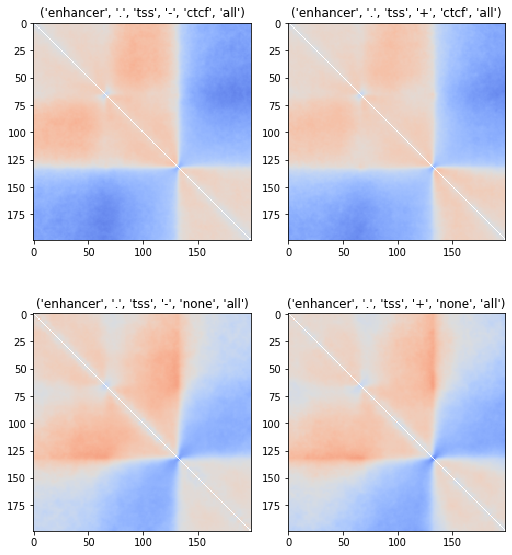

In [103]:
combined_dict = {}
mean_dict = {}
for k,mat in pup_dict["Ctrl500M-CT442-NT.hg19"]["data"].to_dict().items():
    invk = flip_PE(k)
    invmat = mat[::-1,::-1] if k != invk else mat
    # populate combined_dict now
    if invk not in combined_dict:
        combined_dict[invk] = [ invmat ]
    else:
        combined_dict[invk].append(invmat)
        mean_dict[invk] = np.nanmean(combined_dict[invk],axis=0)


fig = plt.figure(figsize=(7,8),constrained_layout=True)
gs = fig.add_gridspec(2,2)
for idx, (name, mat) in enumerate(mean_dict.items()):
    j, i = idx//2, idx%2
    ax = fig.add_subplot(gs[i,j])
    ax.set_title(name)
    img = ax.imshow(
        mat,
        # norm = MidPointLogNorm(vmin=0.75,vmax=1.25,midpoint=1),
        norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25),
        cmap="coolwarm",
        interpolation="nearest",            
    )
# plt.colorbar(img)

<ipython-input-108-602f2639801f>:11: RuntimeWarning: Mean of empty slice
  mean_dict[invk] = np.nanmean(combined_dict[invk],axis=0)


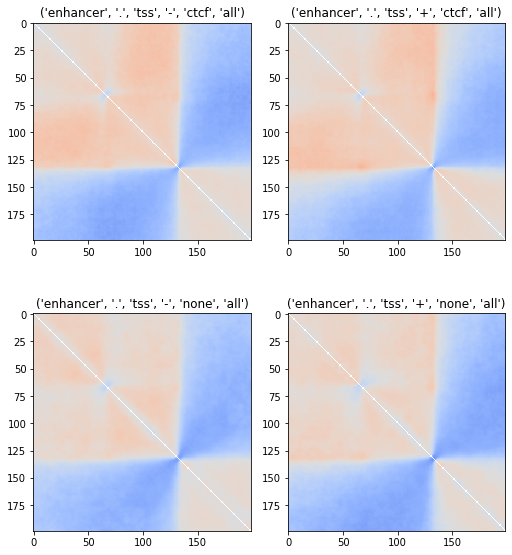

In [108]:
combined_dict = {}
mean_dict = {}
for k,mat in pup_dict["Ctrl500M-CT442-IAA.hg19"]["data"].to_dict().items():
    invk = flip_PE(k)
    invmat = mat[::-1,::-1] if k != invk else mat
    # populate combined_dict now
    if invk not in combined_dict:
        combined_dict[invk] = [ invmat ]
    else:
        combined_dict[invk].append(invmat)
        mean_dict[invk] = np.nanmean(combined_dict[invk],axis=0)


fig = plt.figure(figsize=(7,8),constrained_layout=True)
gs = fig.add_gridspec(2,2)
for idx, (name, mat) in enumerate(mean_dict.items()):
    j, i = idx//2, idx%2
    ax = fig.add_subplot(gs[i,j])
    ax.set_title(name)
    img = ax.imshow(
        mat,
        # norm = MidPointLogNorm(vmin=0.75,vmax=1.25,midpoint=1),
        norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25),
        cmap="coolwarm",
        interpolation="nearest",            
    )
# plt.colorbar(img)

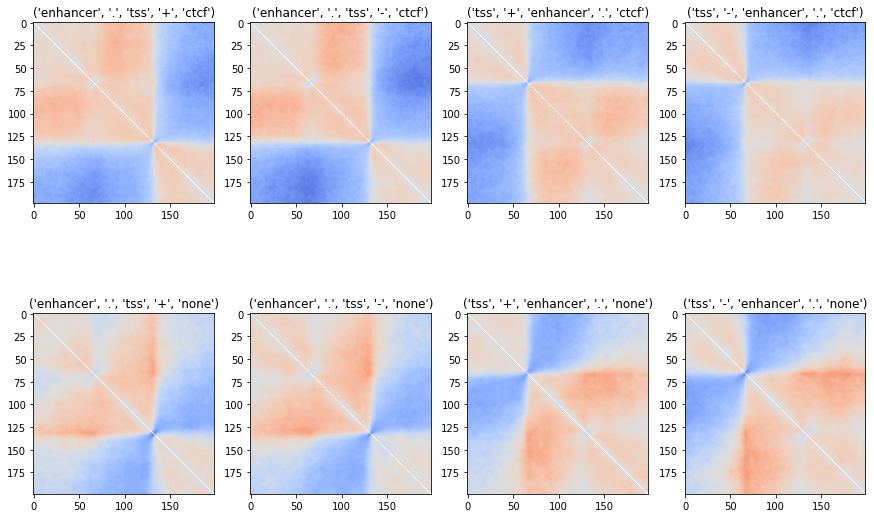

In [47]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(2,len(PE_groups)//2)

_yyyy = pup_dict["Ctrl500M-CT442-NT.hg19"]#.reset_index()#.set_index(["gexp","gsize","orientation"])

for idx, (name, _) in enumerate(PE_groups):
    j, i = idx//2, idx%2
    ax = fig.add_subplot(gs[i,j])
    ax.set_title(name)
    pup_heatmap = _yyyy.loc[name,"data"].values[0]
    img = ax.imshow(
        pup_heatmap,
        # norm = MidPointLogNorm(vmin=0.75,vmax=1.25,midpoint=1),
        norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25),
        cmap="coolwarm",
        interpolation="nearest",            
    )
# plt.colorbar(img)

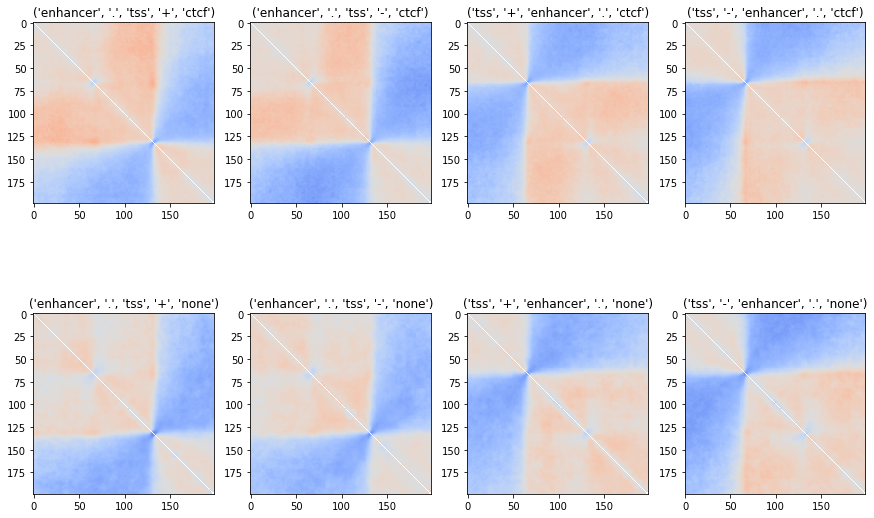

In [48]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(2,len(PE_groups)//2)

_yyyy = pup_dict["Ctrl500M-CT442-IAA.hg19"]#.reset_index()#.set_index(["gexp","gsize","orientation"])

for idx, (name, _) in enumerate(PE_groups):
    j, i = idx//2, idx%2
    ax = fig.add_subplot(gs[i,j])
    ax.set_title(name)
    pup_heatmap = _yyyy.loc[name,"data"].values[0]
    img = ax.imshow(
        pup_heatmap,
        # norm = MidPointLogNorm(vmin=0.75,vmax=1.25,midpoint=1),
        norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25),
        cmap="coolwarm",
        interpolation="nearest",            
    )
# plt.colorbar(img)